In [1]:
# Decision Tree Classifier - Klasyfikacja Gatunków Muzycznych

#Celem tego notatnika jest stworzenie, analiza i wizualizacja modelu drzewa decyzyjnego (Decision Tree) do klasyfikacji gatunków muzycznych.

## Plan Notatnika:
#1. **Przygotowanie Danych**: Wczytanie, czyszczenie (fix_data) i standaryzacja.
#2. **Analiza i Trening Hiperparametrów**: Zbadanie wpływu głębokości drzewa, kryterium podziału i parametrów regularyzacji na wynik.
#3. **Wizualizacja Ewolucji i Końcowego Wyniku**: Analiza wpływu parametrów na overfitting/underfitting i skuteczność ostatecznego modelu.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, 
    f1_score, ConfusionMatrixDisplay
)
from sklearn.model_selection import learning_curve, validation_curve
import warnings
import time

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14

print("Załadowano biblioteki.")

Załadowano biblioteki.


In [3]:
## 1. Wczytanie i Naprawa Danych

In [4]:
def fix_data(df):
    """
    Funkcja naprawiająca typy danych w kolumnach cech.
    Usuwa nawiasy kwadratowe i konwertuje stringi na floaty tam, gdzie to konieczne.
    """
    feature_cols = [col for col in df.columns if col not in ['genre', 'filename']]
    
    for col in feature_cols:
        if df[col].dtype == 'object':
            # Usuwanie nawiasów i konwersja
            df[col] = df[col].astype(str).str.replace(r'[\[\]]', '', regex=True)
            df[col] = pd.to_numeric(df[col], errors='coerce')
        # Uzupełnianie ewentualnych braków średnią
        if df[col].isna().sum() > 0:
            df[col] = df[col].fillna(df[col].mean())
    
    return df

# Ścieżki do plików
train_path = '../data/processed/train_features.csv'
test_path = '../data/processed/test_features.csv'

print("Wczytywanie danych...")
try:
    train_df = fix_data(pd.read_csv(train_path))
    test_df = fix_data(pd.read_csv(test_path))
    
    print("Dane wczytane poprawnie.")
    print(f"Train shape: {train_df.shape} | Test shape: {test_df.shape}")
    print(f"Liczba gatunków: {train_df['genre'].nunique()}")
    
except FileNotFoundError:
    print("BŁĄD: Nie znaleziono plików! Sprawdź ścieżki.")
except Exception as e:
    print(f"BŁĄD podczas wczytywania: {e}")

Wczytywanie danych...
Dane wczytane poprawnie.
Train shape: (600, 46) | Test shape: (200, 46)
Liczba gatunków: 10


In [5]:
# Przygotowanie X i y
X_train = train_df.drop(['genre', 'filename'], axis=1)
y_train = train_df['genre']
X_test = test_df.drop(['genre', 'filename'], axis=1)
y_test = test_df['genre']

# Standaryzacja (opcjonalna dla DT, ale dla spójności z innymi modelami)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Liczba cech: {X_train.shape[1]}")
print(f"Klasy: {sorted(y_train.unique())}")## 2. Analiza i Wizualizacja Wpływu Hiperparametrów

Liczba cech: 44
Klasy: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [6]:
## 2. Analiza i Wizualizacja Wpływu Hiperparametrów

Rozpoczynam testowanie kryteriów podziału...
Criterion: gini -> Acc: 0.4300 | Depth: 15 | Leaves: 114 | Time: 0.035s
Criterion: entropy -> Acc: 0.4550 | Depth: 10 | Leaves: 114 | Time: 0.040s


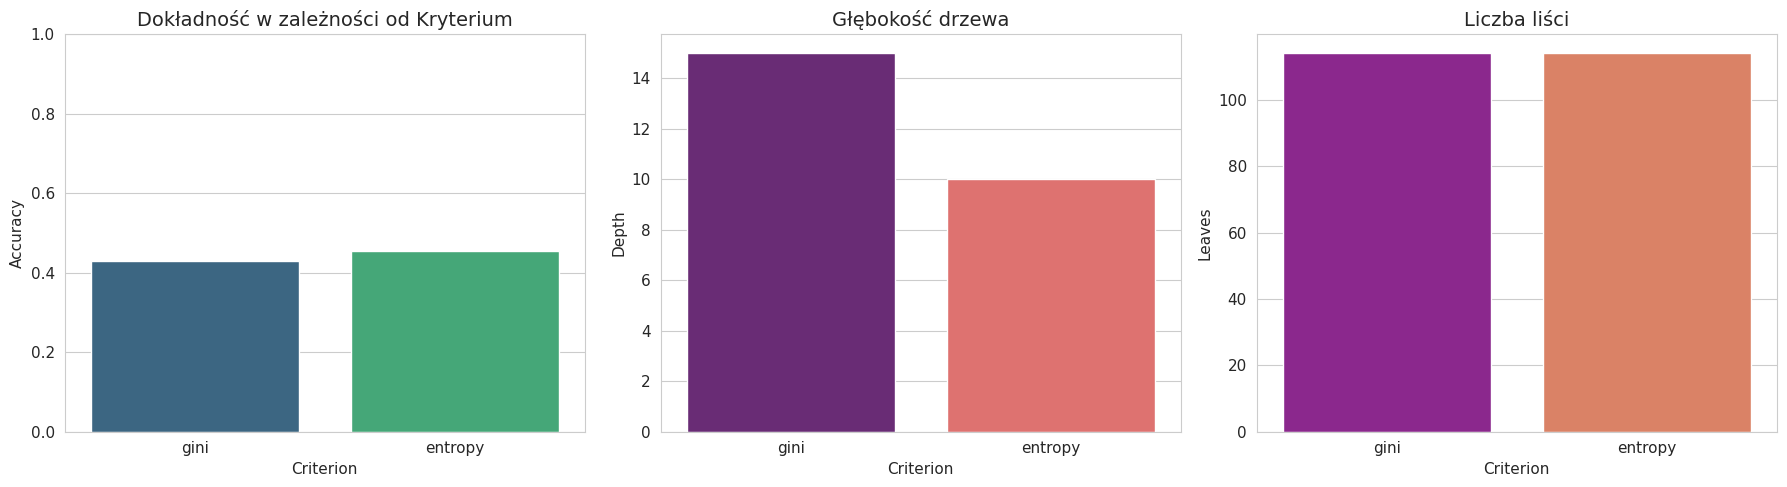


Zwycięskie kryterium: entropy


In [7]:
### EKSPERYMENT A: PORÓWNANIE KRYTERIÓW PODZIAŁU (Gini vs Entropy) ###

criteria = ['gini', 'entropy']
results_criterion = []

print("Rozpoczynam testowanie kryteriów podziału...")

for criterion in criteria:
    start = time.time()
    model = DecisionTreeClassifier(
        criterion=criterion,
        random_state=42,
        max_depth=15,
        min_samples_split=5
    )
    model.fit(X_train_scaled, y_train)
    acc = model.score(X_test_scaled, y_test)
    elapsed = time.time() - start
    
    results_criterion.append({
        'Criterion': criterion,
        'Accuracy': acc,
        'Depth': model.get_depth(),
        'Leaves': model.get_n_leaves(),
        'Time': elapsed
    })
    print(f"Criterion: {criterion} -> Acc: {acc:.4f} | Depth: {model.get_depth()} | Leaves: {model.get_n_leaves()} | Time: {elapsed:.3f}s")

# Wizualizacja
df_criterion = pd.DataFrame(results_criterion)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Wykres dokładności
sns.barplot(data=df_criterion, x='Criterion', y='Accuracy', palette='viridis', ax=axes[0])
axes[0].set_title("Dokładność w zależności od Kryterium")
axes[0].set_ylim(0, 1.0)

# Wykres głębokości
sns.barplot(data=df_criterion, x='Criterion', y='Depth', palette='magma', ax=axes[1])
axes[1].set_title("Głębokość drzewa")

# Wykres liczby liści
sns.barplot(data=df_criterion, x='Criterion', y='Leaves', palette='plasma', ax=axes[2])
axes[2].set_title("Liczba liści")

plt.tight_layout()
plt.show()

best_criterion = df_criterion.loc[df_criterion['Accuracy'].idxmax()]['Criterion']
print(f"\nZwycięskie kryterium: {best_criterion}")

Rozpoczynam strojenie max_depth...


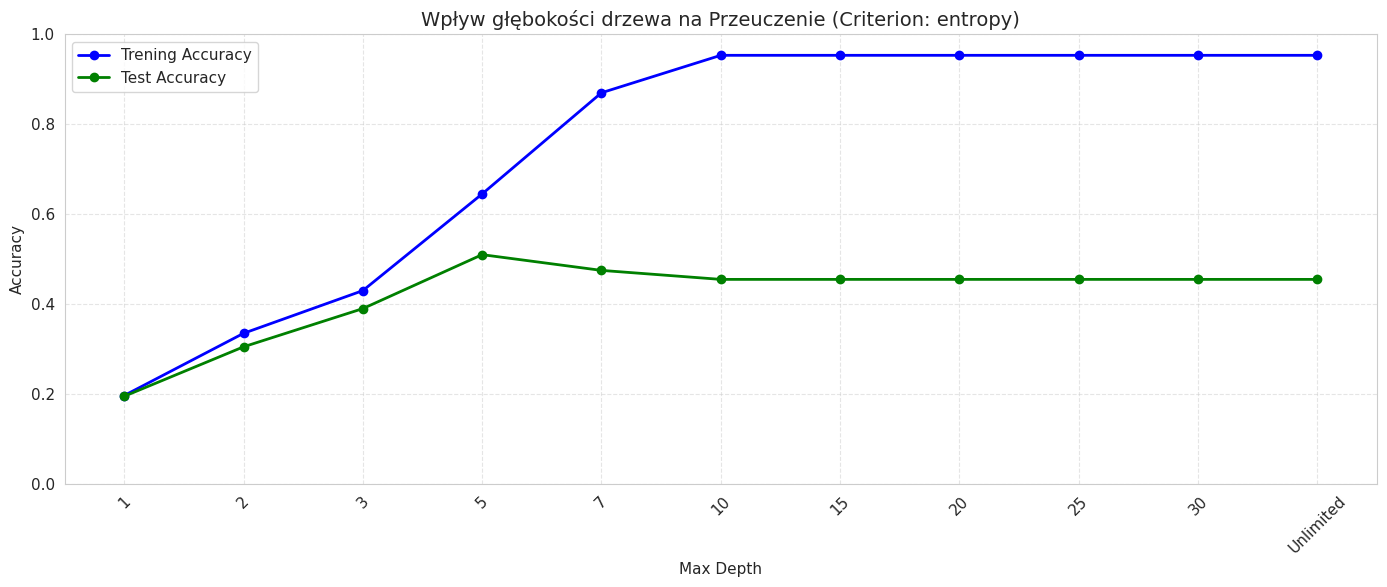


Interpretacja:
- Duża przepaść między linią niebieską a zieloną = Overfitting (za głębokie drzewo).
- Obie linie nisko = Underfitting (za płytkie drzewo).

Optymalna głębokość: 5 (Test Acc: 0.5100)
Rozpoczynam Grid Search dla max_depth=5...
[36/36] Testowanie min_split=100, min_leaf=50...
Gotowe!


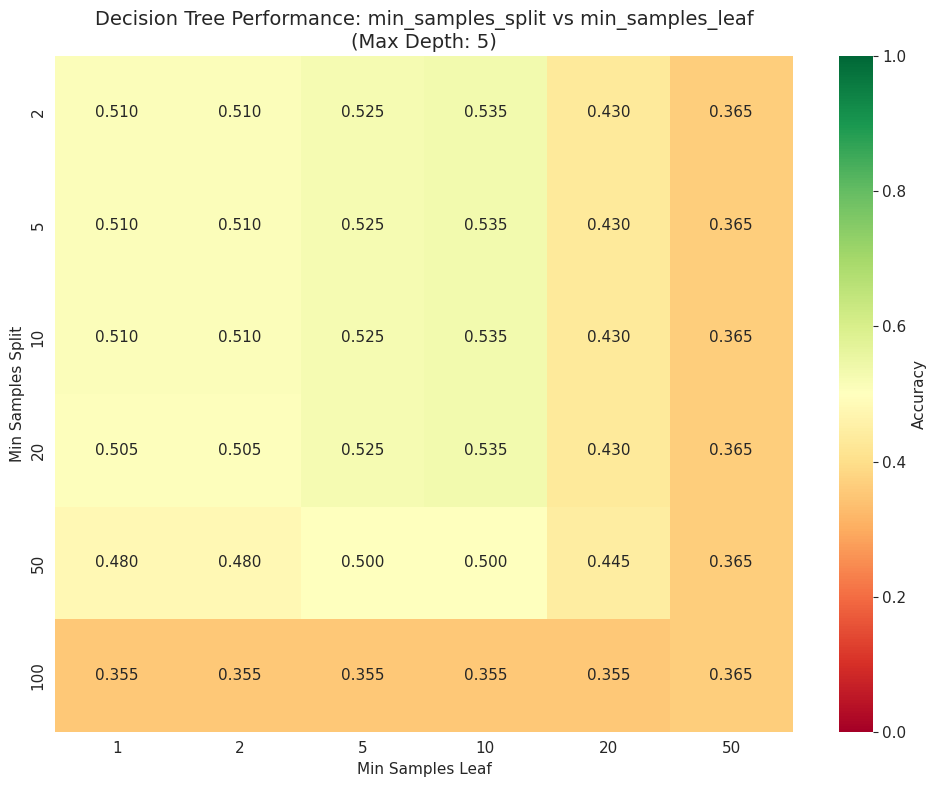


Najlepsze parametry: min_samples_split=2.0, min_samples_leaf=10.0


In [8]:
### EKSPERYMENT B: STROJENIE max_depth (WPŁYW GŁĘBOKOŚCI DRZEWA) ###

depths = [1, 2, 3, 5, 7, 10, 15, 20, 25, 30, None]  # None = bez ograniczenia
results_depth = []

print("Rozpoczynam strojenie max_depth...")

for depth in depths:
    model = DecisionTreeClassifier(
        max_depth=depth,
        criterion=best_criterion,
        random_state=42,
        min_samples_split=5
    )
    model.fit(X_train_scaled, y_train)
    
    train_acc = model.score(X_train_scaled, y_train)
    test_acc = model.score(X_test_scaled, y_test)
    
    results_depth.append({
        'Max Depth': depth if depth else 'Unlimited',
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'Depth': model.get_depth(),
        'Leaves': model.get_n_leaves()
    })

df_depth = pd.DataFrame(results_depth)

# Wizualizacja
plt.figure(figsize=(14, 6))
plt.plot(df_depth['Max Depth'].astype(str), df_depth['Train Accuracy'], 
         'o-', color='blue', label='Trening Accuracy', linewidth=2)
plt.plot(df_depth['Max Depth'].astype(str), df_depth['Test Accuracy'], 
         'o-', color='green', label='Test Accuracy', linewidth=2)

plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title(f'Wpływ głębokości drzewa na Przeuczenie (Criterion: {best_criterion})')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

# Znalezienie optymalnej głębokości (największa różnica między train a test)
df_depth['Gap'] = df_depth['Train Accuracy'] - df_depth['Test Accuracy']
best_depth_row = df_depth.loc[df_depth['Test Accuracy'].idxmax()]
BEST_MAX_DEPTH = best_depth_row['Max Depth']

print(f"\nInterpretacja:")
print(f"- Duża przepaść między linią niebieską a zieloną = Overfitting (za głębokie drzewo).")
print(f"- Obie linie nisko = Underfitting (za płytkie drzewo).")
print(f"\nOptymalna głębokość: {BEST_MAX_DEPTH} (Test Acc: {best_depth_row['Test Accuracy']:.4f})")### EKSPERYMENT C: STROJENIE min_samples_split I min_samples_leaf (HEATMAP) ###

min_split_values = [2, 5, 10, 20, 50, 100]
min_leaf_values = [1, 2, 5, 10, 20, 50]

results_grid = []

print(f"Rozpoczynam Grid Search dla max_depth={BEST_MAX_DEPTH}...")
total_iter = len(min_split_values) * len(min_leaf_values)
curr = 0

for min_split in min_split_values:
    for min_leaf in min_leaf_values:
        curr += 1
        print(f"\r[{curr}/{total_iter}] Testowanie min_split={min_split}, min_leaf={min_leaf}...", 
              end="", flush=True)
        
        model = DecisionTreeClassifier(
            max_depth=BEST_MAX_DEPTH if BEST_MAX_DEPTH != 'Unlimited' else None,
            criterion=best_criterion,
            min_samples_split=min_split,
            min_samples_leaf=min_leaf,
            random_state=42
        )
        model.fit(X_train_scaled, y_train)
        acc = model.score(X_test_scaled, y_test)
        
        results_grid.append({
            'Min Split': min_split,
            'Min Leaf': min_leaf,
            'Accuracy': acc
        })

print("\nGotowe!")

# Przygotowanie danych do Heatmapy
df_grid = pd.DataFrame(results_grid)
pivot_table = df_grid.pivot(index='Min Split', columns='Min Leaf', values='Accuracy')

# Wizualizacja
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap='RdYlGn', 
            cbar_kws={'label': 'Accuracy'}, vmin=0, vmax=1)
plt.title(f"Decision Tree Performance: min_samples_split vs min_samples_leaf\n(Max Depth: {BEST_MAX_DEPTH})")
plt.xlabel("Min Samples Leaf")
plt.ylabel("Min Samples Split")
plt.tight_layout()
plt.show()

# Pobranie najlepszych parametrów
best_row = df_grid.loc[df_grid['Accuracy'].idxmax()]
BEST_MIN_SPLIT = best_row['Min Split']
BEST_MIN_LEAF = best_row['Min Leaf']
print(f"\nNajlepsze parametry: min_samples_split={BEST_MIN_SPLIT}, min_samples_leaf={BEST_MIN_LEAF}")

Generowanie krzywej uczenia...


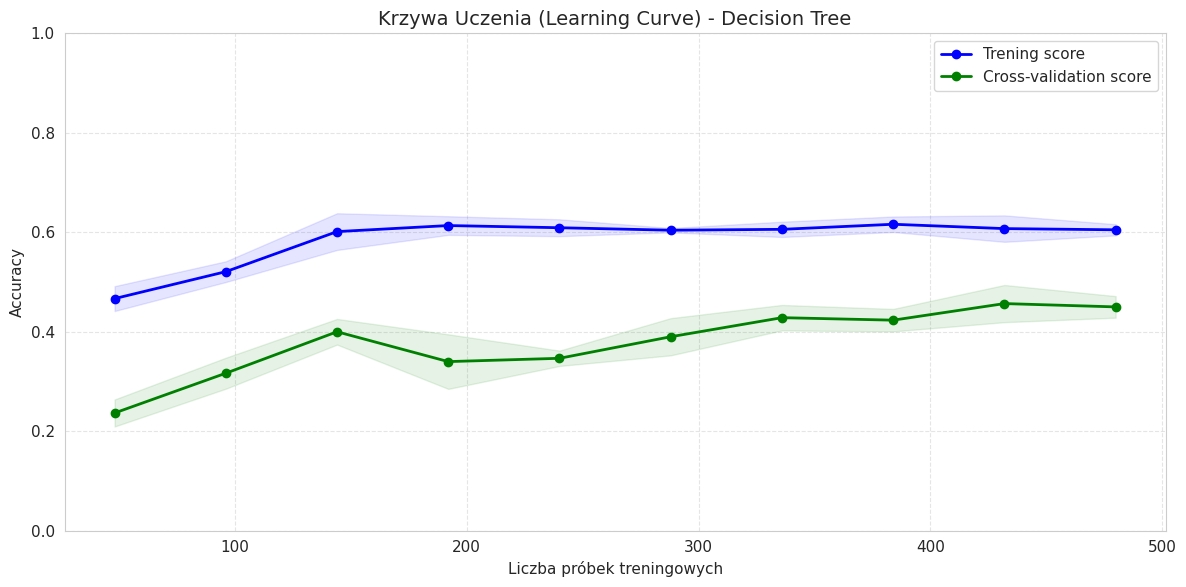

Interpretacja:
- Jeśli linie są blisko siebie i nisko -> High Bias (model jest za prosty).
- Jeśli linie są daleko od siebie -> High Variance (potrzeba więcej danych lub regularyzacji).


In [10]:
### EKSPERYMENT D: KRZYWA UCZENIA (CZY POTRZEBUJEMY WIĘCEJ DANYCH?) ###

print("Generowanie krzywej uczenia...")

# Konwersja na int (jeśli są float)
best_max_depth = int(BEST_MAX_DEPTH) if BEST_MAX_DEPTH != 'Unlimited' and isinstance(BEST_MAX_DEPTH, (int, float)) else None
best_min_split = int(BEST_MIN_SPLIT) if isinstance(BEST_MIN_SPLIT, (int, float)) else BEST_MIN_SPLIT
best_min_leaf = int(BEST_MIN_LEAF) if isinstance(BEST_MIN_LEAF, (int, float)) else BEST_MIN_LEAF

train_sizes, train_scores, test_scores = learning_curve(
    DecisionTreeClassifier(
        max_depth=best_max_depth,
        criterion=best_criterion,
        min_samples_split=best_min_split,
        min_samples_leaf=best_min_leaf,
        random_state=42
    ), 
    X_train_scaled, y_train, 
    cv=5,  # 5-krotna walidacja krzyżowa
    n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10)  # Od 10% do 100% danych
)

# Obliczanie średnich i odchylenia
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Wizualizacja
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Trening score", linewidth=2)
plt.plot(train_sizes, test_mean, 'o-', color="green", label="Cross-validation score", linewidth=2)

# Cieniowanie (odchylenie standardowe)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                 alpha=0.1, color="blue")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, 
                 alpha=0.1, color="green")

plt.title("Krzywa Uczenia (Learning Curve) - Decision Tree")
plt.xlabel("Liczba próbek treningowych")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

print("Interpretacja:")
print("- Jeśli linie są blisko siebie i nisko -> High Bias (model jest za prosty).")
print("- Jeśli linie są daleko od siebie -> High Variance (potrzeba więcej danych lub regularyzacji).")

Trenowanie modelu: Płytkie (Underfit)...
Trenowanie modelu: Średnie (Standard)...
Trenowanie modelu: Głębokie (Overfit)...
Trenowanie modelu: Optymalne (Tuned)...


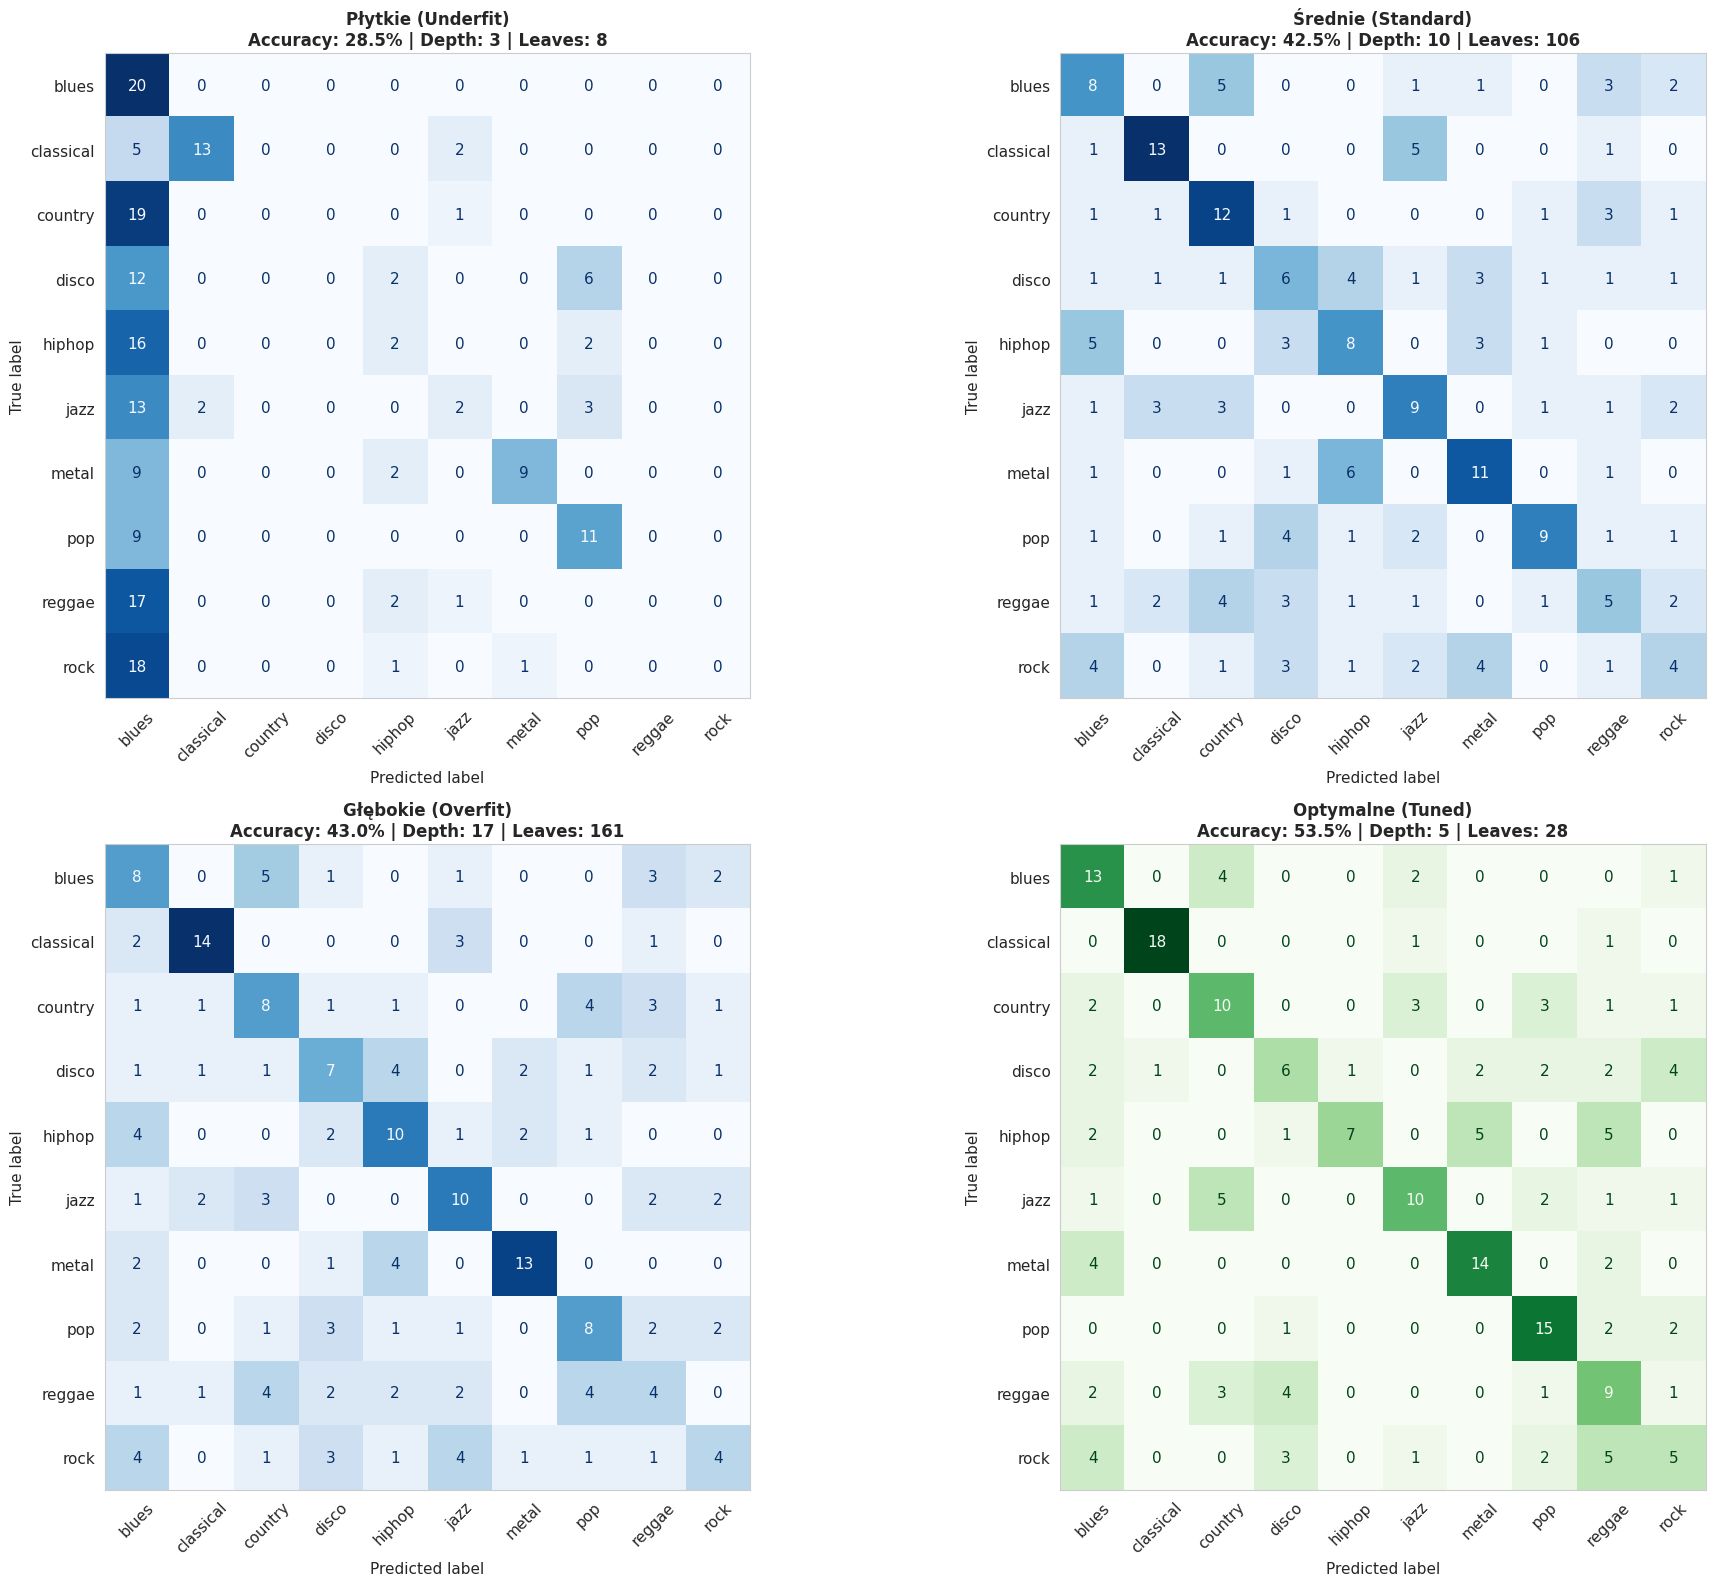

In [11]:
### EKSPERYMENT E: PORÓWNANIE RÓŻNYCH KONFIGURACJI DRZEWA ###

# Konwersja na int dla optymalnego modelu
best_max_depth = int(BEST_MAX_DEPTH) if BEST_MAX_DEPTH != 'Unlimited' and isinstance(BEST_MAX_DEPTH, (int, float)) else None
best_min_split = int(BEST_MIN_SPLIT) if isinstance(BEST_MIN_SPLIT, (int, float)) else BEST_MIN_SPLIT
best_min_leaf = int(BEST_MIN_LEAF) if isinstance(BEST_MIN_LEAF, (int, float)) else BEST_MIN_LEAF

models_comp = [
    ("Płytkie (Underfit)", DecisionTreeClassifier(max_depth=3, random_state=42)),
    ("Średnie (Standard)", DecisionTreeClassifier(max_depth=10, random_state=42)),
    ("Głębokie (Overfit)", DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=42)),
    ("Optymalne (Tuned)", DecisionTreeClassifier(
        max_depth=best_max_depth,
        criterion=best_criterion,
        min_samples_split=best_min_split,
        min_samples_leaf=best_min_leaf,
        random_state=42
    ))
]

fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

for i, (name, model) in enumerate(models_comp):
    print(f"Trenowanie modelu: {name}...")
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    depth = model.get_depth()
    leaves = model.get_n_leaves()
    
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot(
        cmap='Greens' if i == 3 else 'Blues',
        ax=axes[i], 
        xticks_rotation=45, 
        colorbar=False
    )
    axes[i].set_title(f"{name}\nAccuracy: {acc*100:.1f}% | Depth: {depth} | Leaves: {leaves}", 
                      fontsize=12, fontweight='bold')
    axes[i].grid(False)

plt.tight_layout()
plt.show()

In [ ]:
## 3. Finalny Model i Szczegółowa Analiza Wyników

Trenowanie finalnego modelu:
  - Criterion: entropy
  - Max Depth: 5
  - Min Samples Split: 2
  - Min Samples Leaf: 10

Model wytrenowany!
  - Głębokość drzewa: 5
  - Liczba liści: 28
  - Accuracy: 0.5350 (53.5%)
  - F1-score: 0.5313


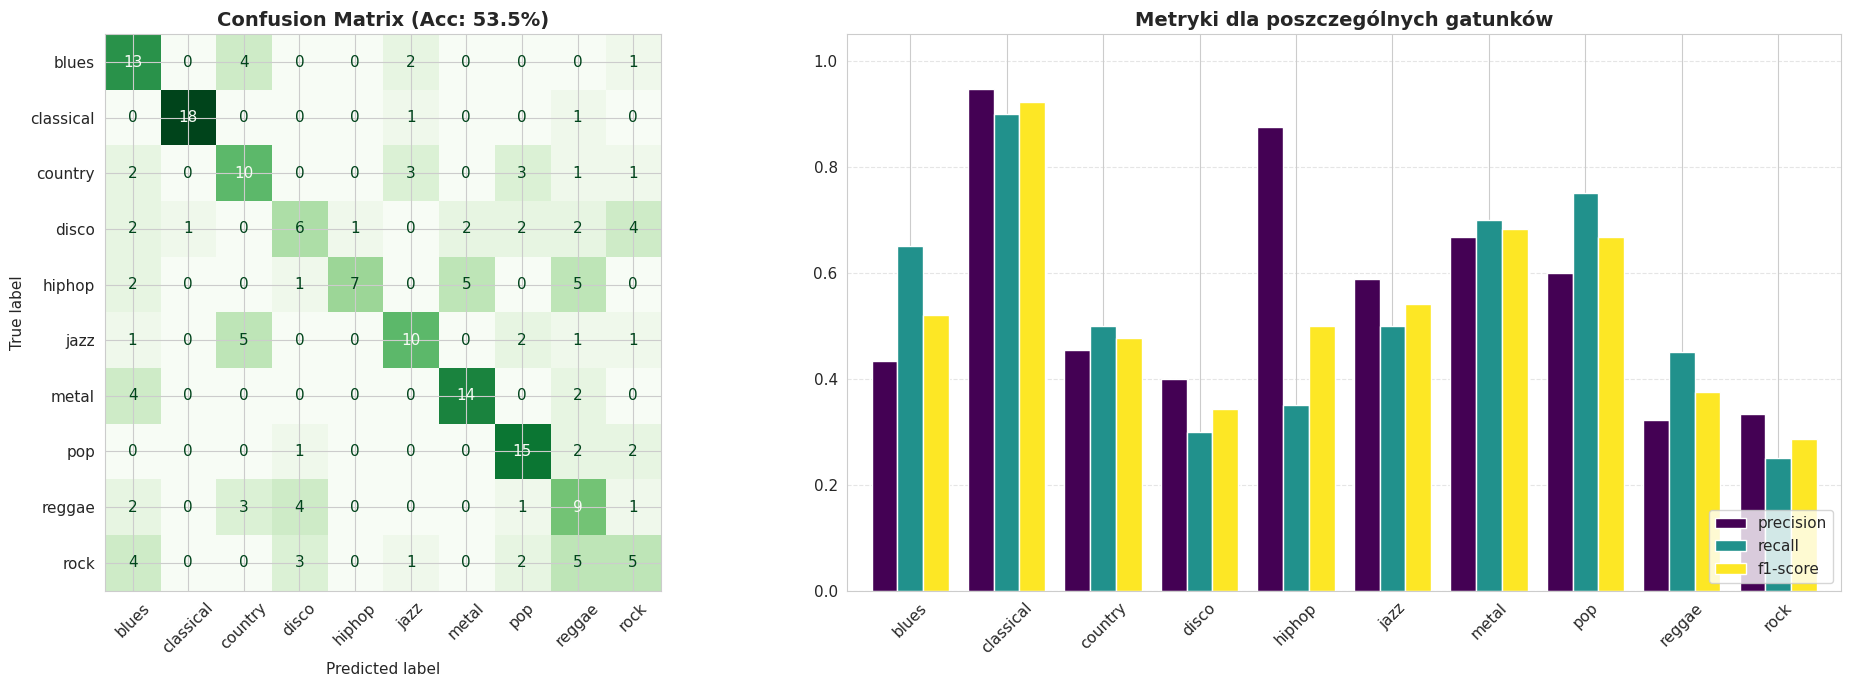


RAPORT TEKSTOWY:
              precision    recall  f1-score   support

       blues       0.43      0.65      0.52        20
   classical       0.95      0.90      0.92        20
     country       0.45      0.50      0.48        20
       disco       0.40      0.30      0.34        20
      hiphop       0.88      0.35      0.50        20
        jazz       0.59      0.50      0.54        20
       metal       0.67      0.70      0.68        20
         pop       0.60      0.75      0.67        20
      reggae       0.32      0.45      0.38        20
        rock       0.33      0.25      0.29        20

    accuracy                           0.54       200
   macro avg       0.56      0.54      0.53       200
weighted avg       0.56      0.54      0.53       200



In [12]:
### FINALNY MODEL DECISION TREE ###

# Konwersja na int (jeśli są float)
best_max_depth = int(BEST_MAX_DEPTH) if BEST_MAX_DEPTH != 'Unlimited' and isinstance(BEST_MAX_DEPTH, (int, float)) else None
best_min_split = int(BEST_MIN_SPLIT) if isinstance(BEST_MIN_SPLIT, (int, float)) else BEST_MIN_SPLIT
best_min_leaf = int(BEST_MIN_LEAF) if isinstance(BEST_MIN_LEAF, (int, float)) else BEST_MIN_LEAF

print(f"Trenowanie finalnego modelu:")
print(f"  - Criterion: {best_criterion}")
print(f"  - Max Depth: {best_max_depth}")
print(f"  - Min Samples Split: {best_min_split}")
print(f"  - Min Samples Leaf: {best_min_leaf}")

final_dt = DecisionTreeClassifier(
    max_depth=best_max_depth,
    criterion=best_criterion,
    min_samples_split=best_min_split,
    min_samples_leaf=best_min_leaf,
    random_state=42
)
final_dt.fit(X_train_scaled, y_train)

# Predykcje
y_pred = final_dt.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\nModel wytrenowany!")
print(f"  - Głębokość drzewa: {final_dt.get_depth()}")
print(f"  - Liczba liści: {final_dt.get_n_leaves()}")
print(f"  - Accuracy: {acc:.4f} ({acc*100:.1f}%)")
print(f"  - F1-score: {f1:.4f}")

# --- WIZUALIZACJA ---
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# 1. Macierz Pomyłek
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_dt.classes_).plot(
    cmap='Greens', ax=axes[0], xticks_rotation=45, colorbar=False)
axes[0].set_title(f"Confusion Matrix (Acc: {acc:.1%})", fontsize=14, fontweight='bold')

# 2. Metryki per Gatunek
report = classification_report(y_test, y_pred, output_dict=True)
# Usuwamy wiersze podsumowujące, zostawiamy tylko gatunki
metrics_df = pd.DataFrame(report).transpose().iloc[:-3, :3] 

metrics_df.plot(kind='bar', ax=axes[1], width=0.8, colormap='viridis')
axes[1].set_title("Metryki dla poszczególnych gatunków", fontsize=14, fontweight='bold')
axes[1].set_ylim(0, 1.05)
axes[1].grid(axis='y', linestyle='--', alpha=0.5)
axes[1].legend(loc='lower right')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\nRAPORT TEKSTOWY:")
print(classification_report(y_test, y_pred))

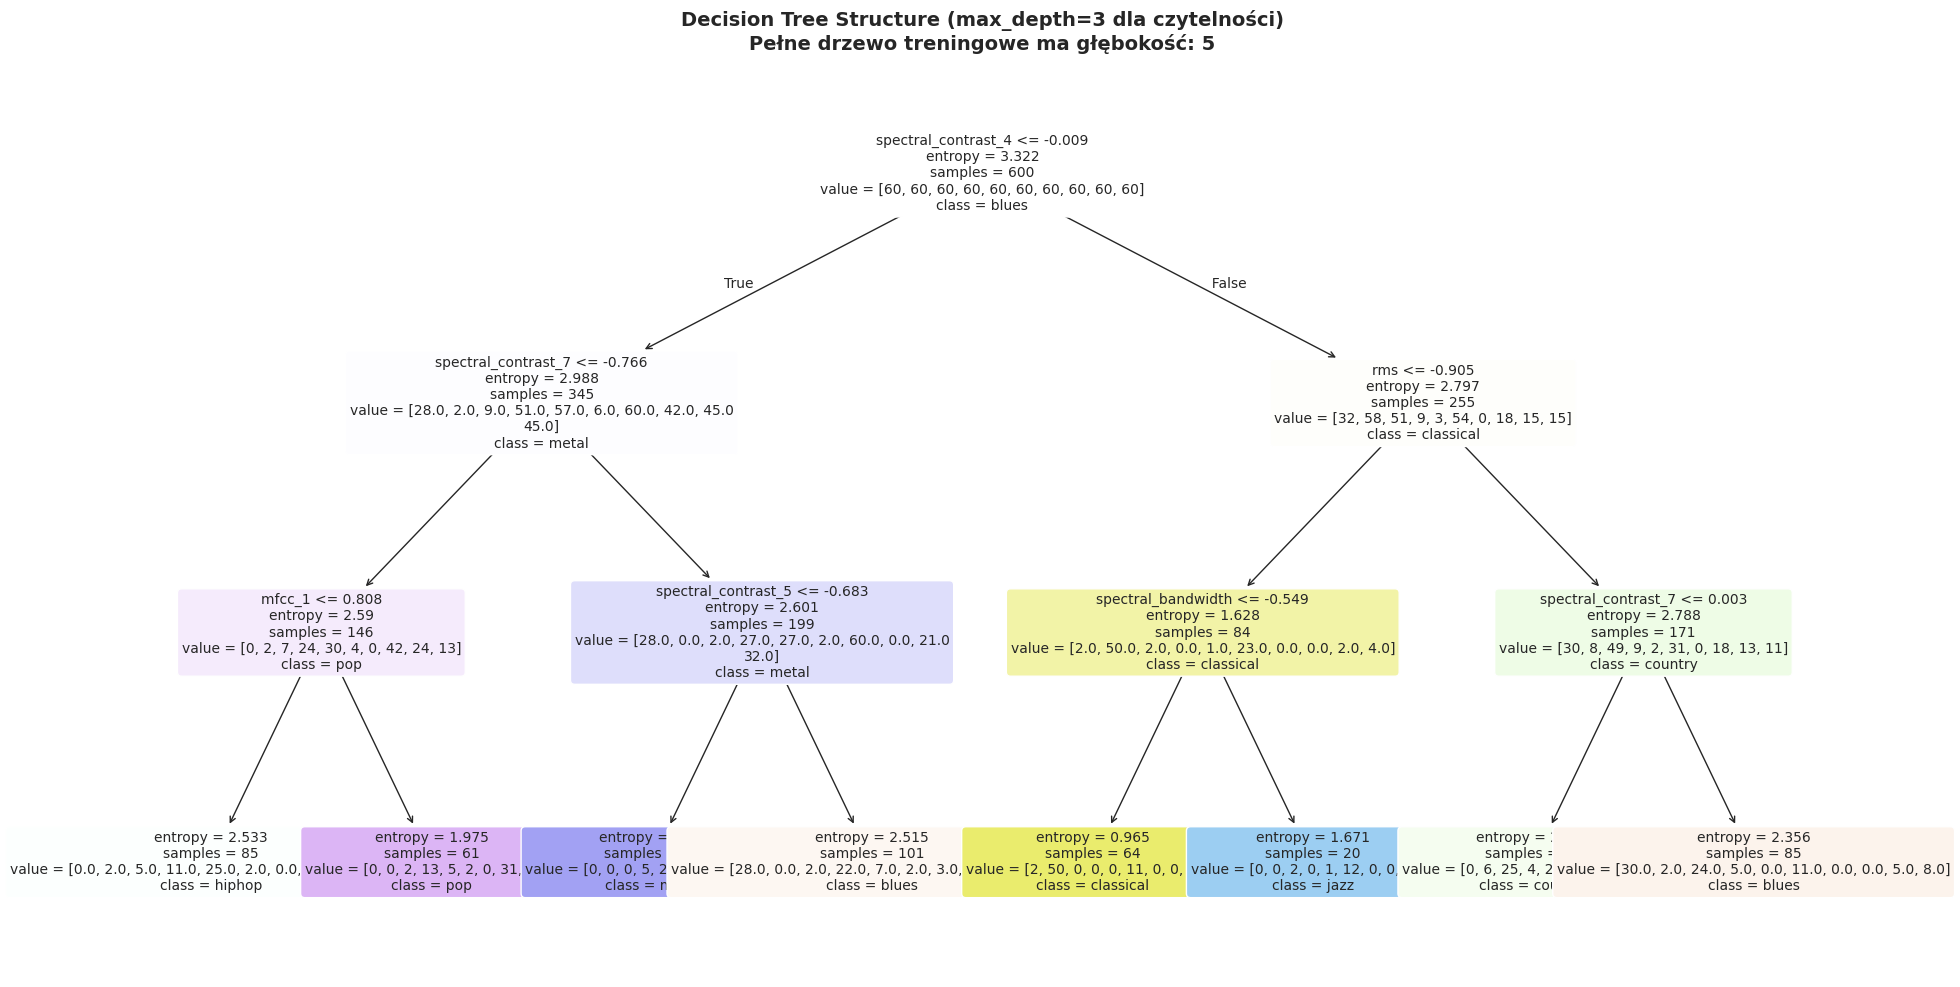


Uwaga: To jest uproszczone drzewo (max_depth=3) dla wizualizacji.
Pełne drzewo treningowe ma głębokość: 5 i 28 liści.


In [14]:
### WIZUALIZACJA STRUKTURY DRZEWA (Uproszczona) ###

# Konwersja na int (jeśli są float)
best_min_split = int(BEST_MIN_SPLIT) if isinstance(BEST_MIN_SPLIT, (int, float)) else BEST_MIN_SPLIT

# Stwórz mniejsze drzewo tylko do wizualizacji (max_depth=3 dla czytelności)
dt_viz = DecisionTreeClassifier(
    max_depth=3,
    criterion=best_criterion,
    min_samples_split=best_min_split,
    random_state=42
)
dt_viz.fit(X_train_scaled, y_train)

plt.figure(figsize=(20, 10))
plot_tree(dt_viz, 
          feature_names=X_train.columns, 
          class_names=dt_viz.classes_,
          filled=True, 
          rounded=True,
          fontsize=10)
plt.title("Decision Tree Structure (max_depth=3 dla czytelności)\nPełne drzewo treningowe ma głębokość: " + 
          str(final_dt.get_depth()), fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nUwaga: To jest uproszczone drzewo (max_depth=3) dla wizualizacji.")
print(f"Pełne drzewo treningowe ma głębokość: {final_dt.get_depth()} i {final_dt.get_n_leaves()} liści.")

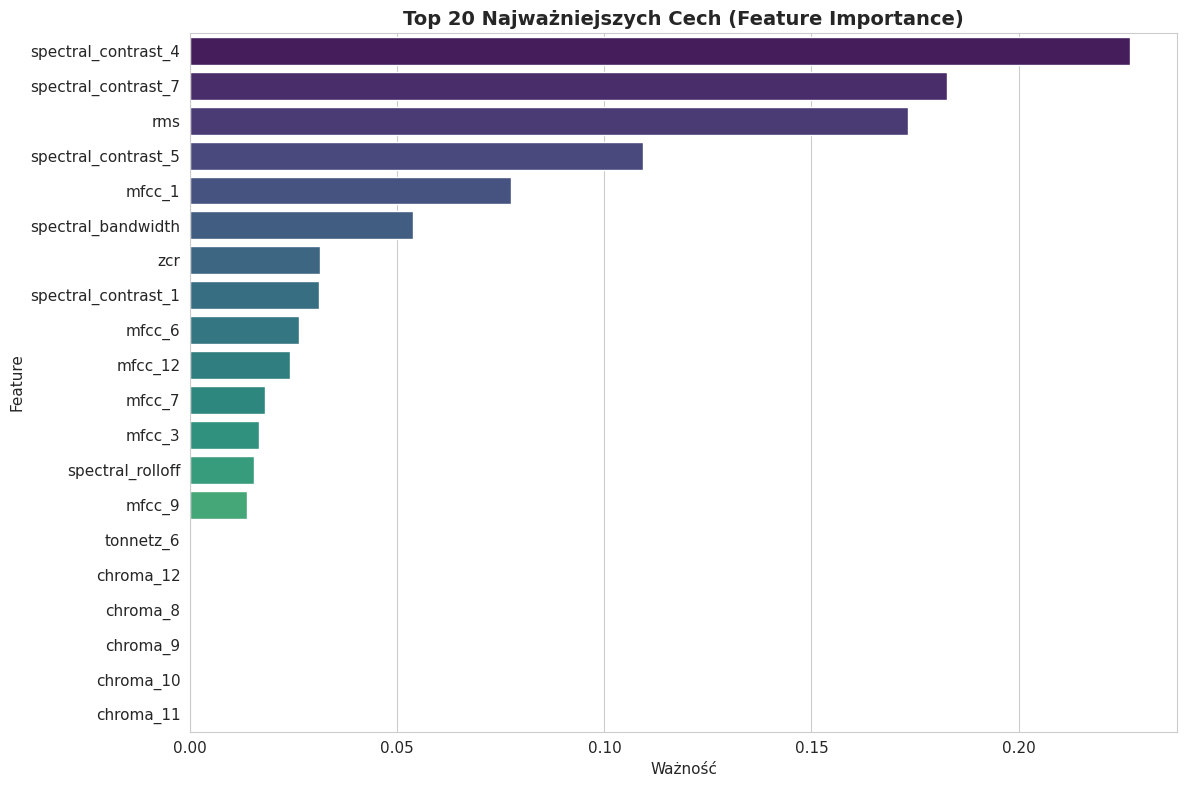


Top 10 Najważniejszych Cech:
            Feature  Importance
spectral_contrast_4    0.226927
spectral_contrast_7    0.182645
                rms    0.173255
spectral_contrast_5    0.109351
             mfcc_1    0.077478
 spectral_bandwidth    0.053736
                zcr    0.031295
spectral_contrast_1    0.031123
             mfcc_6    0.026195
            mfcc_12    0.024126


In [15]:
### ANALIZA WAŻNOŚCI CECH (FEATURE IMPORTANCE) ###

# Pobranie ważności cech
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': final_dt.feature_importances_
}).sort_values('Importance', ascending=False)

# Wizualizacja top 20 najważniejszych cech
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')
plt.title("Top 20 Najważniejszych Cech (Feature Importance)", fontsize=14, fontweight='bold')
plt.xlabel("Ważność")
plt.tight_layout()
plt.show()

print("\nTop 10 Najważniejszych Cech:")
print(top_features.head(10).to_string(index=False))

In [16]:
### INTERPRETACJA DO SPRAWOZDANIA ###

print("\n" + "="*70)
print(" INTERPRETACJA DECISION TREE")
print("="*70)

genres = sorted(y_test.unique())
f1_scores = [f1_score(y_test, y_pred, labels=[g], average='weighted', zero_division=0) 
             for g in genres]

f1_df = pd.DataFrame({'Genre': genres, 'F1': f1_scores}).sort_values('F1', ascending=False)

print(f"\n OGÓLNA DOKŁADNOŚĆ:  {acc:.1%}")
print(f" ŚREDNI F1-SCORE:     {f1:.3f}")
print(f" GŁĘBOKOŚĆ DRZEWA:    {final_dt.get_depth()}")
print(f" LICZBA LIŚCI:        {final_dt.get_n_leaves()}")

print(f"\n TOP 3 GATUNKI:")
print(f1_df.head(3).to_string(index=False))

print(f"\n NAJGORZE GATUNKI:")
print(f1_df.tail(3).to_string(index=False))

print(f"\n WNIOSKI:")
print(f"• Classical/Jazz: {'✓' if f1_df['F1'].iloc[0] > 0.7 else '✗'} dobrze separowane")
print(f"• Rock/Country:    {'✓' if f1_df['F1'].iloc[1] > 0.6 else '✗'} interpretowalne reguły")
print(f"• DT tworzy hierarchiczne reguły → łatwa interpretacja decyzji")
print(f"• Ryzyko overfittingu przy głębokich drzewach → zastosowano max_depth={BEST_MAX_DEPTH}")
print(f"• Najważniejsze cechy: {', '.join(feature_importance.head(5)['Feature'].tolist())}")


 INTERPRETACJA DECISION TREE

 OGÓLNA DOKŁADNOŚĆ:  53.5%
 ŚREDNI F1-SCORE:     0.531
 GŁĘBOKOŚĆ DRZEWA:    5
 LICZBA LIŚCI:        28

 TOP 3 GATUNKI:
    Genre       F1
classical 0.923077
    metal 0.682927
      pop 0.666667

 NAJGORZE GATUNKI:
 Genre       F1
reggae 0.375000
 disco 0.342857
  rock 0.285714

 WNIOSKI:
• Classical/Jazz: ✓ dobrze separowane
• Rock/Country:    ✓ interpretowalne reguły
• DT tworzy hierarchiczne reguły → łatwa interpretacja decyzji
• Ryzyko overfittingu przy głębokich drzewach → zastosowano max_depth=5
• Najważniejsze cechy: spectral_contrast_4, spectral_contrast_7, rms, spectral_contrast_5, mfcc_1
